# Creating a model
<br> what our model does :
* starts with random values(weight and bias)
* look at the training data and adjust the weight and bias to better represent the ideal valueswe used to create the data. <br>
<br>
but how does it do so ? By: <br>

- Gradient descent
- Backpropagation

In [21]:
# previous datas : form 06
# create known parameters 
weight=0.7
bias=0.3
start=0
end=1
step=0.02
X =torch.arange(start,end,step).unsqueeze(dim=1) #input numbers
y=weight*X + bias # output numbers


# Splitting the data into training and test datasets :
train_split=int(len(X)*0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test=X[train_split:], y[train_split:]

#check the data split :
len(X_train), len(y_train), len(X_test), len(y_test)

# plotting the data

def plot_predictions(train_data=X_train,
                          train_labels=y_train,
                          test_data=X_test,
                          test_labels=y_test,
                          predictions=None
                         ):

    """
    Plots training data, test data and compares predictions 
    """
    plt.figure(figsize=(10,7))
    
    
    # training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training_data")
    
    #test data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing_data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    # show the legend
    plt.legend(prop={"size":14});

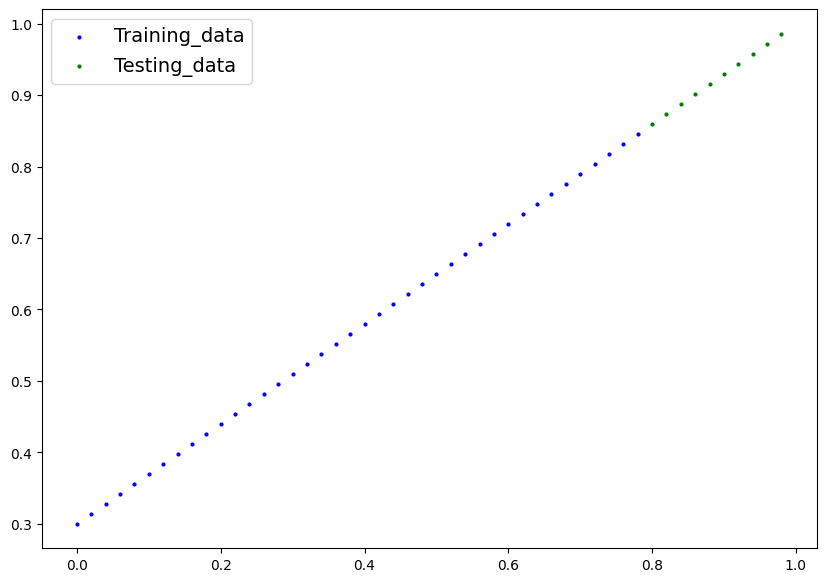

In [22]:
plot_predictions();

In [23]:
# importing
try: 
    import torch
    import numpy
    import matplotlib.pyplot as plt
    from torch import nn # nn-> all te building blocks for a neural network
    print("Done Successfully")
except Exception as e:
    print("Failed to import",e)
# from last class :
weight=0.7
bias=0.3

Done Successfully


In [24]:
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch inherits nn.model
    def __init__(self):
        super().__init__()
        self.weights=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float)) #start with a random weight then adjust it to ideal weight
        self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float)) #start with a random bias then adjust it to ideal weight

    #forward method to define the computation in the model
    def forward(self,x: torch.Tensor) ->torch.Tensor: #x is the input data
        return self.weights*x + self.bias #linear regression formula
        
        

# Some of the model building essentials:
- torch.nn : contains all of the building buildings for computational graphs/ neural network.
- nn.Parameter : what parameters should our model try and learn(often a pytorch layer from torch.nn will set this for us)
- torch.nn.Module : base class for all our neural network modules, if we subclass it, we should create our own forward mehod.
- torch.optim: this is where optimizers live. they help with gradient descent


 

In [25]:
# checking whats inside our model using `.parameter()`
rand_seed=42
torch.manual_seed(rand_seed)

model_0=LinearRegressionModel()

print(list(model_0.parameters()),"\n") #since this can be confusing, we use model.state_dict()
print(model_0.state_dict())


[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)] 

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


In [26]:
# make a prediction using `torch.inference_mode()`
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [27]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


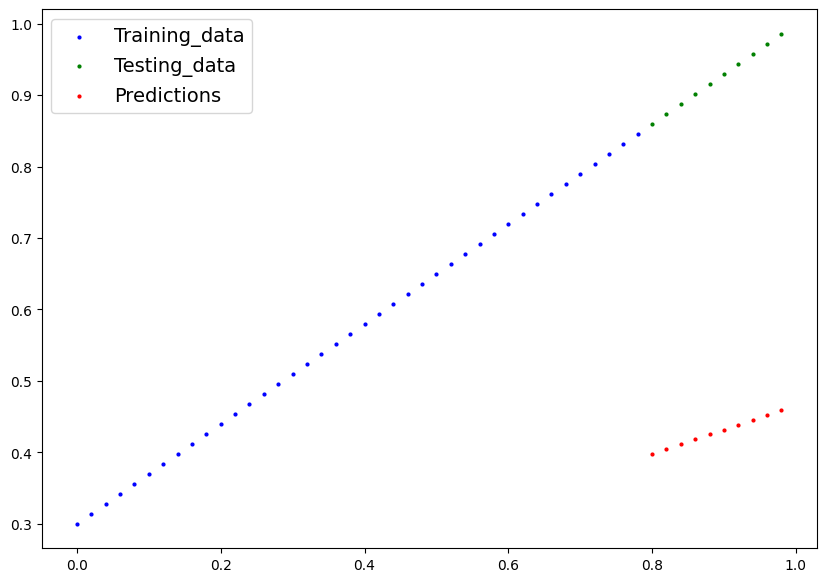

In [28]:
plot_predictions(predictions=y_preds)

# Train the model
- Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

- To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.

Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.


In [29]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


In [30]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


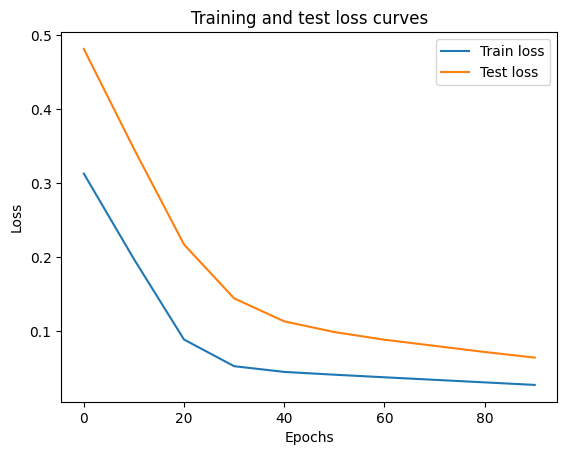

In [31]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [32]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Making predictions with a trained PyTorch model (inference)
Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

Set the model in evaluation mode (model.eval()).
Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).
The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [33]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

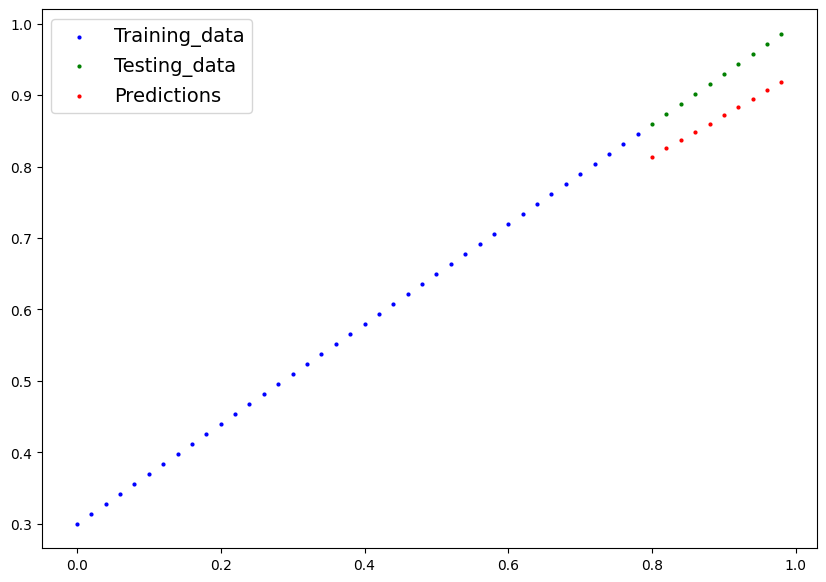

In [34]:
plot_predictions(predictions=y_preds)